# Predicción de Rating de Películas por Usuarios
  Morán Pérez Derek Saúl

Usando los datos proporcionados, se requiere realizar un modelo de Machine Learning el cual sirva
para predecir cómo un usuario (con características como edad, sexo, ocupación, zip code y un
historial de películas calificadas) calificará una película que no ha visto.

## Importación de los datos

Se tienen 3 bases de datos con información sobre películas, usuarios y ratings, estos archivos son de tipo .dat, en este caso los datos que contiene son de tipo texto, al abrir los archivos podemos notar dos cosas:

  - Los datos están separados por un caracter ": :", por lo que podemos encontrar los datos como:

  1::F::1::10::48067

  2::M::56::16::70072

  3::M::25::15::55117

  - Los datos no tienen título, lo que podría complicar el entendimiento sobre a qué se refiere cada uno de los datos, afortunadamente la carpeta dónde se encuentran los datos cuenta con un archivo README que nos da la información necesaria sobre el significado de cada uno de estos valores.

En la importación de los datos vamos a asignar a cada base un valor diferente y finalmente unirlas por una columna en común que también podemos conocer gracias al README.

In [272]:
#Importación de las bases de datos
#Se intentó cargar los datos directamente, pero estos no están codificacos con utf-8, por lo que el comando por defecto de pandas no pudo leer este archivo, haciendo uso de chardet
#se obtuvo que los datos son tipo ISO-8859-1 con una confianza del 73%
import pandas as pd

df = pd.read_csv('/content/movies.dat', sep = '::', engine = 'python', encoding = 'ISO-8859-1', names = ['MovieID', 'Title', 'Genres'])
print("Base de Películas")
print("\n", df.head())

df2 = pd.read_csv('/content/ratings.dat', sep = '::', engine = 'python', encoding = 'ISO-8859-1', names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
print("\nBase de Ratings")
print("\n", df2.head())

df3 = pd.read_csv('/content/users.dat', sep = '::', engine = 'python', encoding = 'ISO-8859-1', names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
print("\nBase de Usuarios")
print("\n", df3.head())



Base de Películas

    MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Base de Ratings

    UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Base de Usuarios

    UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20   

Las bases serán unidas de la siguiente manera:

Base de Películas + Base de Ratings según el MovieID

Base de Ratings y Películas + Base de Usuarios según el UserID

Obteniendo así una base final que incluya la información de las 3 bases de datos

Pero antes de eso, dentro del archivo README se nos indica que algunos IDs de películas pueden no estar asignados a un título de película debido también a posibles duplicados, por lo que tenemos que tener esto en cuenta, para esto primero revisaremos que las bases no tengan datos nulos o duplicados

In [273]:
df.isna().sum()

,0
MovieID,0
Title,0
Genres,0


In [274]:
df2.isna().sum()

,0
UserID,0
MovieID,0
Rating,0
Timestamp,0


In [275]:
df3.isna().sum()

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zip-code,0


No se tienen datos nulos en ninguna de las bases de datos, o almenos no son datos NA, aún pueden ser datos que contengan caracteres inesperados que se deberán tomar como datos nulos.


In [276]:
#Duplicados en la base Movies: en este caso podemos observar duplicados según dos factores, el ID que son números del 1 al 3952 o al título de la película, primero veremos si hay
#duplicados en el ID

duplicados = df[df.duplicated(subset='MovieID', keep=False)]
print(duplicados)



Empty DataFrame
Columns: [MovieID, Title, Genres]
Index: []


In [277]:
#Duplicados en la base Ratings, para esta base de datos hay que considerar que un usuario puede dar múltiples ratings a diversas películas, por lo que no podemos usar UserID para verificar
#duplicados, pero tampoco podemos usar MovieID ya que una película puede recibir diversos ratigns de varios usuarios, por lo que veremos si un usuario tiene registrado más de un rating
#a una misma película y de esta forma conocer si hay duplicados

duplicados = df2[df2.duplicated(subset=['UserID', 'MovieID'], keep=False)]

print(duplicados)

Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp]
Index: []


In [278]:
#Para la base de Usuarios, de igual forma nos queda únicamente observar el userID
duplicados = df3[df3.duplicated(subset='UserID', keep=False)]
print(duplicados)

Empty DataFrame
Columns: [UserID, Gender, Age, Occupation, Zip-code]
Index: []


No se presentaron datos duplicados, pero también se nos indica que algunos de los títulos de las películas pueden presentar inconsistencias o errores, para esto se hará uso de una herramienta llamada OpenRefine, puesto que esta tiene dentro de sus parámetros una manera de comparar datos de tipo texto según la similitud y de esta forma veremos si hay algún título que haya presentado errores de escritura.


In [279]:
#Para realizar la experimentación en OpenRefine primero es necesario descargar la base de datos en un archivo .csv, después de manejarlo lo volveremos a subir

df.to_csv('movies.csv', index=False )

Para hacerse una idea sobre lo que hace OpenRefine, es buscar mediante el método de KNN usando la distancia Levenshtein, los nombres de películas más cercanos, o que más parecen coincidir, los selecciona y te da un valor que podrías asignar a este grupo, la siguiente imagen muestra una breve muestra del resultado al analizar esta base de datos:

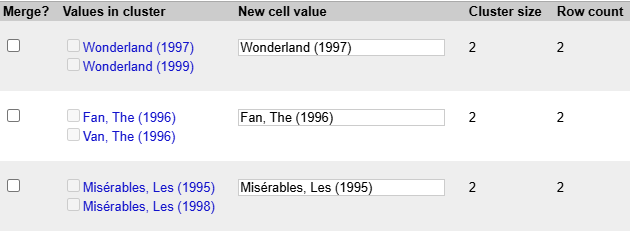

Aunque parezca que algunas de estas pueden ser fusionadas en una sola, la verdad es que cada una es una película diferente gracias a que se tiene la información del año, esto lo comprobamos mediante una búsqueda rápida en la web, por lo que parece que definitivamente no hay duplicados, aunque aún pueden haber errores de imputación en los datos, pero esto no es algo seguro y tendremos que verlo a lo largo del proyecto si aparecen estos errores, por lo que continuaremos con la fusión de las 3 bases de datos en base al índice antes mencionado.

La fusión se hará usando un método inner, para conservar únicamente los registros que tengan coincidencias, ya que como se mencionó, algunos id de películas pueden no estar relacionado a una película directamente, y ya que vimos que no se tenían datos vacios o duplicados, puede ser que hagan referencia a que lo que falte sean algunos id directamente.



In [280]:
fusion = pd.merge(df2, df, on='MovieID', how='inner')

fusion.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [281]:
df = pd.merge(df3, fusion, on = 'UserID', how = 'inner')

df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,F,1,10,48067,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,F,1,10,48067,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


Ya que tenemos los datos preparados con las bases proporcionadas, vamos a hacer columnas extras a partir de la columna genres, para de esta forma separar los múltiples géneros que tenga una película y tomarlo por separado, tengamos en cuenta que esto va a generar datos nulos, puesto que hay películas que tienen más de un género y otras que no, por lo que desde este momento podemos asumir que haremos uso de un modelo que permita manejar o que no sea tan sensible a los datos nulos, el cual será un RandomForest por las características mencionadas, pero en síntesis es debido a que:

  - Es un modelo que tiene una alta capacidad para la clasificación y regresión, en este caso hablamos de un modelo que permita predecir la calificación que dará un usuario a una película que no fue vista antes, por lo que en base a los gustos que esta persona tenga de las películas de algún género, edad, ocupación, sexo, incluso ubicación, podemos obtener una calificación a una película no antes vista, por lo que hablamos de un modelo de aprendizaje supervisado.

  - Este modelo es robusto ante datos nulos hasta cierto punto, lo importante es remarcar que los datos ya fueron trabajados para no tener datos nulos hasta ahora, y los nulos que se generarán al separar la columna de Genres serán pocos en comparación al total, por lo que esto no debería presentar un problema serio.



In [282]:
#Para crear las columnas extras primero necesitamos conocer cuál es la mayor cantidad de géneros que podemos esperar en una película, por lo que contamos la cantidad de separadores |
#que se tienen, y además sumamos uno, ya que cada separador viene entre dos cadenas de texto, por ejemplo en el caso: Animation|Children's|Musical hay 2 separadores y tres géneros, osease 2+1
df['Genres'].str.count('\|').max() + 1

#La mayor cantidad de géneros en una película es de 6, por lo que esperaremos hasta 6 columnas extra

6

In [283]:
#Separamos los géneros en listas
# Dividir la columna 'Genres' por el separador '|'
#df[['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6']] = df['Genres'].str.split('|', expand=True)

#df.head()

En este punto, para tratar los nulos se me ocurrió generar nuevas filas mostrando la película y cada género, entonces para una película con 2 géneros se van a tener 2 registros, evitando así tener las columnas con datos nulos, puesto que fueron más de los esperados ya que la mayoría de películas parecen presentar menos de 3 géneros, pero hay hasta 6 columnas de géneros, estos registros múltiples no deberían crear problemas, puesto que lo importante es ver la calificación que se da en base a un género, de igual manera sería interesante ver como se desempeña un rating según la combinación de géneros, pero esto presenta un costo computacional mayor.

Al crearse estos duplicados también se tendrá el dúplicado del título de la película, pero realmente esta columna no será de importancia en el modelo final, ya que se espera que un rating dependa quizás del género, edad, ocupación, incluso de la zona dónde viva una persona, pero no del título como tal.

In [284]:
#creando los duplicados

#obtenemos la lista de los géneros separándolas según el valor |
df['Genres'] = df['Genres'].str.split('|')

#Pasamos la lista a crear múltiples filas
df = df.explode('Genres')

df.head(10)

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical
2,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical
2,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Romance
3,1,F,1,10,48067,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,F,1,10,48067,2355,5,978824291,"Bug's Life, A (1998)",Animation
4,1,F,1,10,48067,2355,5,978824291,"Bug's Life, A (1998)",Children's
4,1,F,1,10,48067,2355,5,978824291,"Bug's Life, A (1998)",Comedy


Esto además nos podrá permitir hacer gráficas que incluyan o tengan que ver con el género, lo que hará mejor manejable el proyecto.

Cómo última cosa en esta sección, hemos hablado de que la ubicación puede llegar a influir en los gustos de una persona, pues para saber si esto es verdad, vamos a unir esta base de datos con una base que incluye el Zip-code y el estado al cual pertenece este zipcode, la base fue obtenida de: https://www.unitedstateszipcodes.org/48067/

Pero antes de hacer esta otra fusión, los zipcodes proporcionados por esta base contienen únicamente los primeros números, mientras que en la base que tenemos de películas se tienen número separados por guiones, estos no están en la base de zipcodes, por lo que primero debemos manejar estos datos con guiones

In [285]:
df['Zip-code'] = df['Zip-code'].str.split('-').str[0]

df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical
2,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical


In [286]:
df4 = pd.read_csv('/content/zip_code_database.csv')

df4.head()

,Zip-code,state
0,501,NY
1,544,NY
2,601,PR
3,602,PR
4,603,PR


En este caso la fusión será por la izquierda, para asegurarnos de mantener todos los datos de la tabla de películas, aquellos datos que lleguen a faltar en la columna zipcode pueden ser agregados manualmente después.

In [287]:
df['Zip-code'] = df['Zip-code'].astype(str)
df4['Zip-code'] = df4['Zip-code'].astype(str)

#df = pd.merge(df, df4, on = 'Zip-code', how = 'left')

#df.head()

In [288]:
df.isna().sum()

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zip-code,0
MovieID,0
Rating,0
Timestamp,0
Title,0
Genres,0


Se generaron datos vacios en la nueva columna estado, veamos cuales son estos Zip-code que generaron los datos vacios y vamos a imputarlos manualmente

In [289]:
#faltantes = df[df['state'].isna()]

#zipcodes_faltantes = faltantes['Zip-code'].unique()
#print(zipcodes_faltantes)


Podemos ver que son muchos los que faltan, pero hay que darnos cuenta porque no habían coincidencias, primero que nada debemos saber que los zipcode en Estados Unidos cuentan con 5 caracteres, empezando desde el 00501 hasta el 99950, en la base de películas los zipcode sí están bien escritos, es decir, si es un zipcode con numeración menor a 10000 se tiene el 0 que le precede, mientras que en la base de zipcode esto no es así, por ejemplo, para el caso del zipcode 00501 en la base de peliculas, se tiene el zipcode 501 en la de zipcodes, por lo que la coincidencia no se da, y esto ocurre en más casos, además de algunos casos dónde los zipcode vienen con una extensión más larga, por lo que debemos:

1.- Agregar un 0 antes a todos los zipcode del 501 al 9999

2.- Conservar únicamente los primeros 5 digitos que aparezcan para deschar todos los demás

Comencemos a trabajar la base de zipcode.

In [290]:
#primeros 5 dígitos
df4['Zip-code'] = df4['Zip-code'].str.extract(r'(\d{1,5})')

#ceros a la izquierda
df4['Zip-code'] = df4['Zip-code'].str.zfill(5)


In [291]:
df = pd.merge(df, df4, on = 'Zip-code', how = 'left')

df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,state
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,MI
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation,MI
2,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's,MI
3,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical,MI
4,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical,MI


In [292]:
df.isna().sum()

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zip-code,0
MovieID,0
Rating,0
Timestamp,0
Title,0
Genres,0


In [293]:
faltantes = df[df['state'].isna()]

zipcodes_faltantes = faltantes['Zip-code'].unique()
print(zipcodes_faltantes)


['64043' '98153' '98765' '5849574' '21559' '90214' '99945' '34567'
 '345567' '45904' '13907' '2020010' '01234' '61665' '92100' '06430'
 '495321' '94214' '96153' '22112' '02254' '64920' '86701' '94410' '02430'
 '31311' '75005' '98100' '20795' '444555' '80687' '88076' '34170' '33720'
 '81679' '08461' '400060' '78267' '41706' '92965' '61600' '00231' '06680'
 '55100' '14982' '361069' '111225' '0956456' '04309' '95952' '970025'
 '949702' '193122042' '81291' '27245' '10625' '43650' '01125' '191004'
 '05273' '02146' '01597' '91428' '96930' '954025']


Podemos ver que aún hay algunos que no coinciden, en este caso son pertenecientes a la columna del df original, por lo que tenemos que manejarnos igual para mantener únicamente los primeros 5 dígitos

In [294]:
#primeros 5 dígitos
df['Zip-code'] = df['Zip-code'].str.extract(r'(\d{1,5})')

In [295]:
df = pd.merge(df, df4, on = 'Zip-code', how = 'left')

df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,state_x,state_y
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,MI,MI
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation,MI,MI
2,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's,MI,MI
3,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical,MI,MI
4,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical,MI,MI


In [296]:
df.isna().sum()

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zip-code,0
MovieID,0
Rating,0
Timestamp,0
Title,0
Genres,0


In [297]:
faltantes = df[df['state_y'].isna()]

zipcodes_faltantes = faltantes['Zip-code'].unique()
print(zipcodes_faltantes)


['64043' '98153' '98765' '21559' '90214' '99945' '34567' '34556' '45904'
 '13907' '20200' '01234' '61665' '92100' '06430' '49532' '94214' '96153'
 '22112' '02254' '64920' '86701' '94410' '02430' '31311' '75005' '98100'
 '20795' '80687' '88076' '34170' '33720' '81679' '08461' '78267' '41706'
 '92965' '61600' '00231' '06680' '55100' '14982' '11122' '04309' '95952'
 '81291' '27245' '10625' '43650' '01125' '19100' '05273' '02146' '01597'
 '91428' '96930']


In [298]:
#Eliminar'state_x'
df.drop(columns=['state_x'], inplace=True)

#Renombrar
df.rename(columns={'state_y': 'State'}, inplace=True)

In [299]:
df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,State
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,MI
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation,MI
2,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's,MI
3,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical,MI
4,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical,MI


Vamos a crear un diccionario que nos permita asignar un valor de Estado a cada uno de los zipcode faltantes, la información de dónde se buscaron estos códigos fue mediante una búsqueda sencilla en google y obteniendo el primer valor de resultado.

In [300]:
diccionario = {
    '64043': 'MO',
    '98153': 'WA',
    '98765': 'AK',
    '21559': 'MD',
    '90214': 'CA',
    '99945': 'AK',
    '34567': 'FL',
    '34556': 'FL',
    '45904': 'OH',
    '13907': 'NY',
    '20200': 'DC',
    '01234': 'MA',
    '61665': 'IL',
    '92100': 'CA',
    '06430': 'CT',
    '49532': 'MI',
    '94214': 'CA',
    '96153': 'CA',
    '22112': 'VA',
    '02254': 'MA',
    '64920': 'MO',
    '86701': 'AZ',
    '94410': 'CA',
    '02430': 'MA',
    '31311': 'GA',
    '75005': 'TX',
    '98100': 'WA',
    '20795': 'MD',
    '80687': 'CO',
    '88076': 'NM',
    '34170': 'FL',
    '33720': 'FL',
    '81679': 'CO',
    '08461': 'NJ',
    '78267': 'TX',
    '41706': 'KY',
    '92965': 'CA',
    '61600': 'IL',
    '00231': 'MA',
    '06680': 'CT',
    '55100': 'MN',
    '14982': 'NY',
    '11122': 'NY',
    '04309': 'ME',
    '95952': 'CA',
    '81291': 'CO',
    '27245': 'NC',
    '10625': 'NY',
    '43650': 'OH',
    '01125': 'MA',
    '19100': 'PA',
    '05273': 'VT',
    '02146': 'MA',
    '01597': 'MA',
    '91428': 'CA',
    '96930': 'GU'
}


In [301]:
#rellenar nulos con el diccionario

df['State'] = df['State'].fillna(df['Zip-code'].map(diccionario))

In [302]:
df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,State
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,MI
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation,MI
2,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's,MI
3,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical,MI
4,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical,MI


In [303]:
df.isna().sum()

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zip-code,0
MovieID,0
Rating,0
Timestamp,0
Title,0
Genres,0


Ya que finalmente terminamos de tratar lo datos, comenzaremos con el análisis exploratorio de datos.

In [304]:
#En este documento se encuentra la base de datos final

df.to_csv("pelicula.csv", index=False)

## Análisis Exploratorio de Datos

En esta sección vamos a mostrar algunas gráficas e información que pueda ser relevante al momento de decidir cómo hacer nuestro modelo, comenzaremos primero observando algunas relaciones entre las variables y su correlación junto con la variable de interés, es decir, el rating, para observar cuales son nuestras variables que tengan influencia junto con esta y de esta forma comenzar con la eliminación de algunas columnas, logrando así tener un ahorro de costo computacional.

Para empezar, comenzaremos desechando el ZipCode, al tener los estados correspondientes podemos tener menos información que la columna zipcode, ya que un mismo estado puede tener varios códigos postales, la variable timestamp tampoco parece tener mucha utilidad en general, así como el título de la película no suele influir en los gustos de una persona, si no más bien el contenido de la misma lo que quiere decir que eliminaremos la columna Title.

De esta forma conservamos únicamente las columnas Gender, Age, Occupation, MovieID, Genres, State y Rating como target.

Aún no haremos la eliminación de estas columnas, puesto que serán de utilidad para generar las gráficas de esta sección, pero serán eliminadas posteriormente.

Veamos primero que tan desbalanceada tenemos la información, esto con la finalidad de ver que tipo de solución podamos dar según que tan desbalanceados estén los datos.

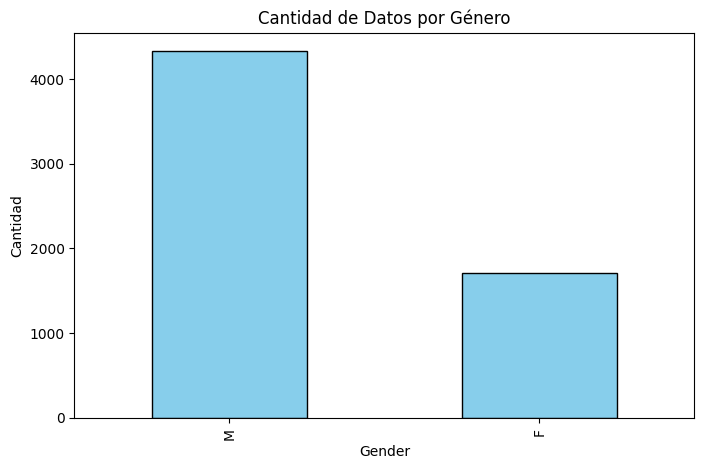

In [305]:
import matplotlib.pyplot as plt

#Desbalanceo en Gender, primero tengamos en cuenta que un usuario puede verse más de una vez, así que primero tenemos que considerar los usuarios sin duplicados
usuarios = df.drop_duplicates(subset='UserID')

conteo = usuarios['Gender'].value_counts()

plt.figure(figsize=(8, 5))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Gender")
plt.ylabel("Cantidad")
plt.title("Cantidad de Datos por Género")
plt.show()

In [306]:
conteo

,count
Gender,
M,4331
F,1709


Podemos ver que tenemos casi más de 2600 de usuarios masculinos a comparación de los femeninos, esto presenta un alto desbalanceo, la mejor forma de solucionarlo será mediante una división estratificada al momento de separar los datos en conjuntos de prueba y entrenamiento.

Veamos ahora la cantidad de entradas que tenemos por rangos de edad.

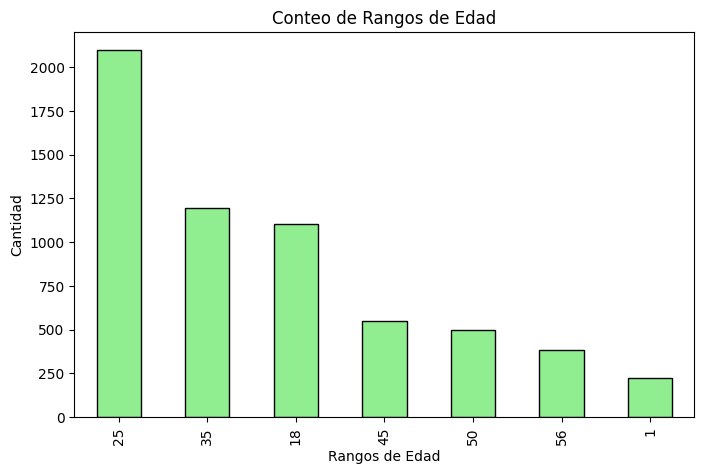

In [307]:
#Desbalanceo en Rango de Edad, para esto volvemos a usar la base usuarios donde ya no hay duplicados de usuarios
conteo = usuarios['Age'].value_counts()

plt.figure(figsize=(8, 5))
conteo.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel("Rangos de Edad")
plt.ylabel("Cantidad")
plt.title("Conteo de Rangos de Edad")
plt.show()

In [308]:
conteo

,count
Age,
25,2096
35,1193
18,1103
45,550
50,496
56,380
1,222


Primero es importante recordar que significa cada uno de los rangos de edad que tenemos presentes:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

Lo que indica que tenemos más usuarios en un rango de 25-34 años y tenemos muy pocos usuarios menores a 18 años, de nueva cuenta esto podría solucionarse mediante la división estratificada de datos, pero en este caso de rangos de edad se vuelve algo complicado, ya que mientras tenemos más de 2000 datos de personas con un rango de edad 25-34, tenemos únicamente cerca de 250 datos de menores de 18 años, esto podría sesgar nuestro modelo, pero el modelo random forest es robusto, por lo que no debería presentar un problema serio.

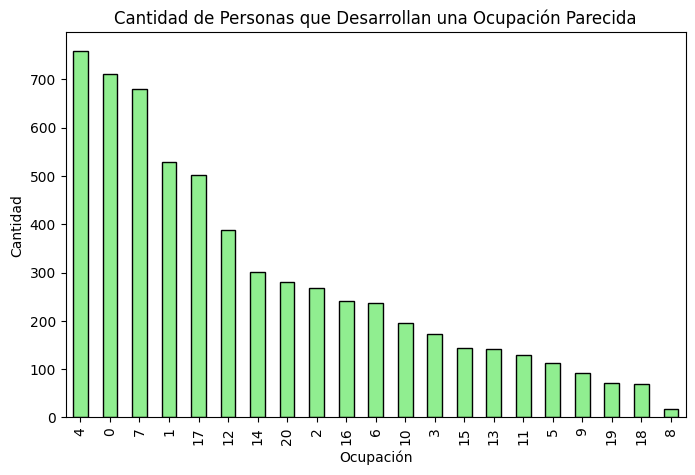

In [309]:
#Desbalanceo en Occupation, para esto volvemos a usar la base usuarios donde ya no hay duplicados de usuarios
conteo = usuarios['Occupation'].value_counts()

plt.figure(figsize=(8, 5))
conteo.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel("Ocupación")
plt.ylabel("Cantidad")
plt.title("Cantidad de Personas que Desarrollan una Ocupación Parecida")
plt.show()

In [310]:
conteo

,count
Occupation,
4,759
0,711
7,679
1,528
17,502
12,388
14,302
20,281
2,267


Las ocupaciones se definieron de la siguiente manera:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

  Podemos ver que tenemos más datos de estudiantes de universidad, que se encontrarían en un rango de edad entre los 18 y 24 años en su mayoría, presentando hasta 759 usuarios, mientras que sólo se tienen 17 personas que realizan actividades de granjero.

Vamos a ver ahora el comportamiento de la variable Rating, observando la media, mediana y moda, junto con la gráfica respectiva que nos permita ver que tan desbalanceada está esta característica, esto es de importancia, ya que esta será nuestro target.

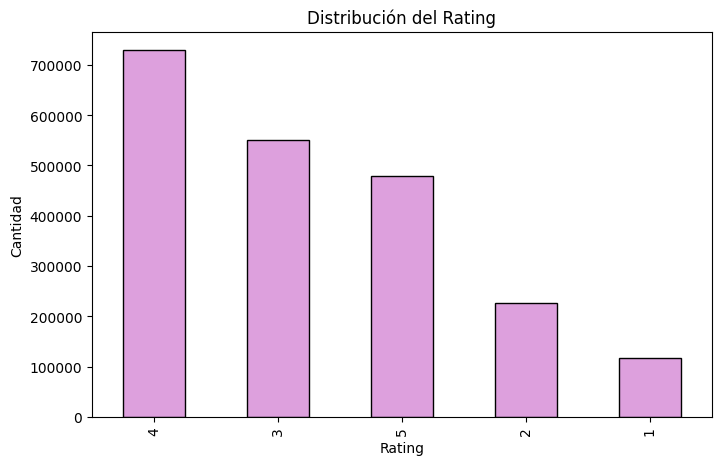

In [311]:
#Desbalanceo en Rating
conteo = df['Rating'].value_counts()

plt.figure(figsize=(8, 5))
conteo.plot(kind='bar', color='plum', edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Cantidad")
plt.title("Distribución del Rating")
plt.show()


In [312]:
conteo

,count
Rating,
4,729065
3,550989
5,477934
2,227224
1,116603


En cuanto al rating, podemos ver que el desbalanceo no es muy fuerte en cuanto a la cantidad presente de 4, 3 y 5 estrellas, pero hay una baja al momento de observar 2 y 1 estrella, este desbalanceo si puede afectar el modelo, ya que este es nuestro target.

Nuevamente el modelo RF es un poco robusto al desbalance, pero no es inmune, este desbalanceo aún puede afectar bastante al modelo tendiendo a favorecer las clases mayoritarías, afortunadamente dentro de los hiperparámetros del modelo mencionado podemos modificar class_weight, ajustando así el peso que tendrá cada clase y evitando problemas, esto suele tener un buen desempeño en general.

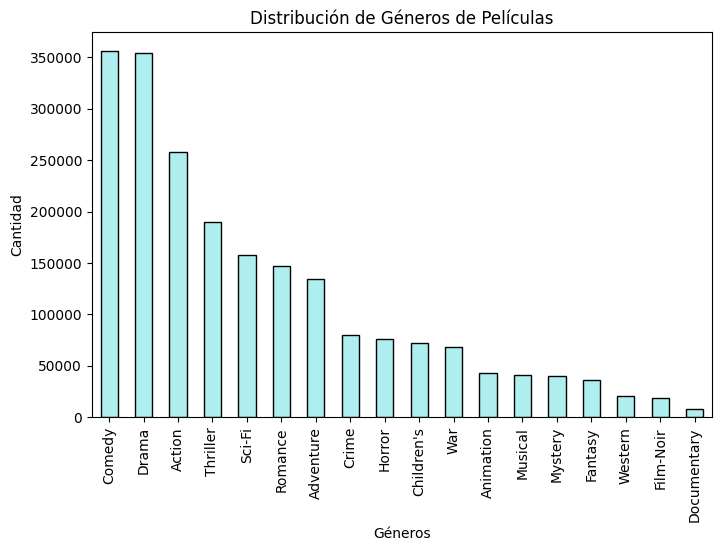

In [313]:
conteo = df['Genres'].value_counts()

plt.figure(figsize=(8, 5))
conteo.plot(kind='bar', color='paleturquoise', edgecolor='black')
plt.xlabel("Géneros")
plt.ylabel("Cantidad")
plt.title("Distribución de Géneros de Películas")
plt.show()

In [314]:
conteo

,count
Genres,
Comedy,356580
Drama,354529
Action,257457
Thriller,189680
Sci-Fi,157294
Romance,147523
Adventure,133953
Crime,79541
Horror,76386


El desbalanceo presente en los géneros si es más notorio que en las demás características.

Mientras que se tienen más de 300K de datos sobre películas de Drama y Comedia, se tienen únicamente 7910 datos sobre Documentales, lo que podría indicar que nuestro modelo se llegue a sesgar hacia los géneros populares y casi no tener en cuenta los documentales

Veamos un poco más de información que podemos obtener a partir de estos datos.

/tmp/ipython-input-315-855132639.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genres', y='Rating', data=df, palette=paleta)


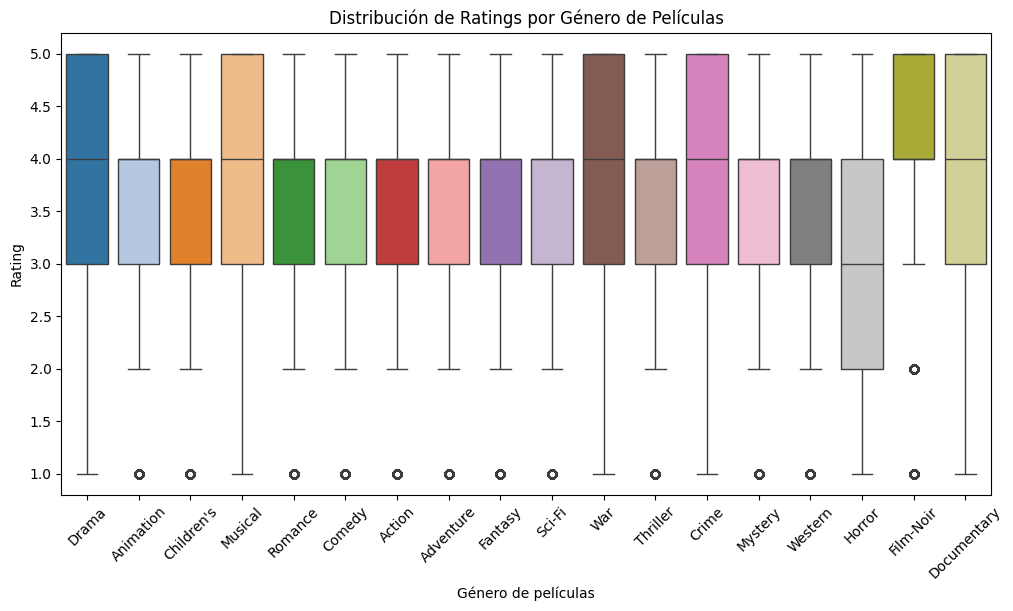

In [315]:
import seaborn as sns

paleta = sns.color_palette("tab20", 18)
plt.figure(figsize=(12,6))
sns.boxplot(x='Genres', y='Rating', data=df, palette=paleta)
plt.xticks(rotation=45)
plt.title('Distribución de Ratings por Género de Películas')
plt.xlabel('Género de películas')
plt.ylabel('Rating')
plt.show()

Esta boxplot nos puede dar algo de información:

- **Drama, Musical, War, Crime y Documentary**: Estas películas tinen una distribución amplia, existiendo películas desde una estrella hasta 5, sin que las películas de 1 estrella se presenten como datos atípicos, así que si bien hay películas de este género que no son bien recibidas, no son tan pocas como para considerarse un dato atípico.

- **Animation, Children's, Romance, Comedy, Action, Adventure, Fantasy, Sci-Fi, Thriller, Mystery, Western**: Todos estos géneros de películas tienen un comportamiento bastante similar, mostrando medianas relativamente altas, y la mayoría de sus datos concentrados entre 3 y 4 estrellas, llegando a tener algunas cuantas películas con 5 y 2 estrellas, pero presentando muy pocas películas mal recibidas con una sola estrella.

- **Horror**: Este género de películas parece ser el peor recibido por las personas, teniendo la mayoría de sus calificaciones centradas entre 2 y 4 estrellas, aún con esto llegan a tener películas con 1 y 5 estrellas.

- **Film-Noir**: Este parece ser el género mejor recibido por nuestros usuarios, ya que la mayoría de sus calificaciones se encuentra entre 4 y 5 estrellas, siendo los más altos, aún con esto existen algunas películas que no fueron bien recibidas con 1 y 2 estrellas.

/tmp/ipython-input-316-3425790397.py:3: UserWarning: The palette list has more values (18) than needed (7), which may not be intended.
  sns.boxplot(x='Genres', y='Rating', hue='Age',data=df, palette=paleta)


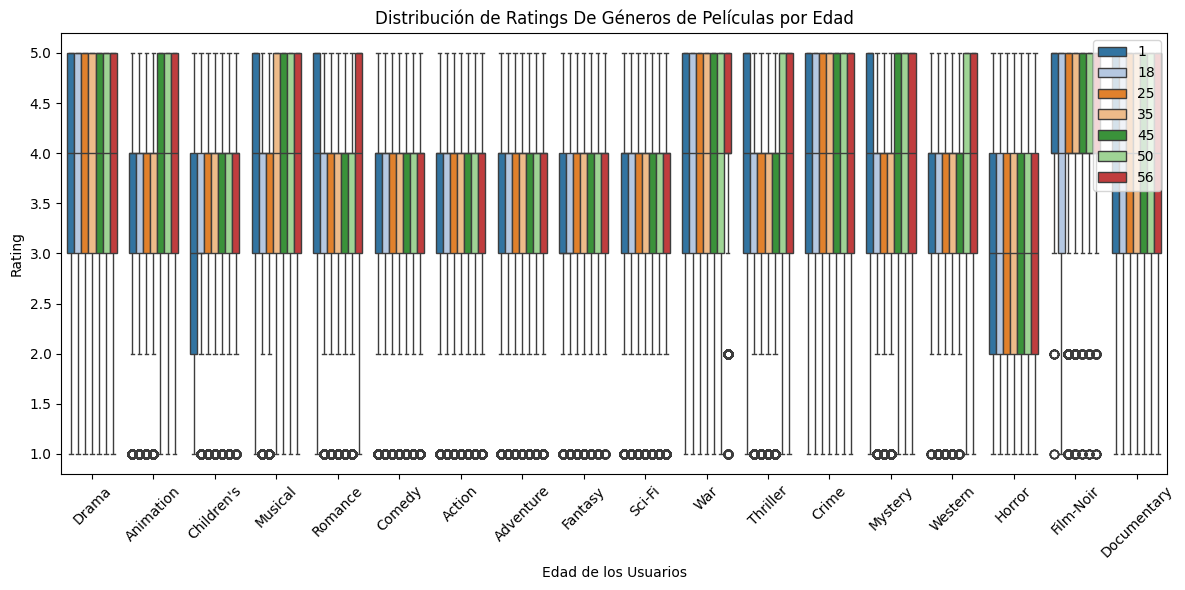

In [316]:
paleta = sns.color_palette("tab20", 18)
plt.figure(figsize=(12,6))
sns.boxplot(x='Genres', y='Rating', hue='Age',data=df, palette=paleta)
plt.xticks(rotation=45)
plt.title('Distribución de Ratings De Géneros de Películas por Edad')
plt.xlabel('Edad de los Usuarios')
plt.ylabel('Rating')
plt.legend(title='Grupo de Edad')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

La información presentada por esta gráfica indica:

- **Drama, Crime, Documentary**: Las calificaciones de este género de películas es indiferente para el grupo de edad, mostrando en su mayoría calificaciones altas.

- **Animación**: Este género de película presenta calificaciones más altas para las personas con más de 45 años, mientras que para personas menores a esta edad se encuentran calificaciones en su mayoría de 3 a 4 estrellas, aún con esto, estos grupos de menor edad a 45 calificaron pocas películas con 1 estrella, mientras que los de 45+ llegaron a dar más calificaciones de 1 estrellam teniendo más variabilidad en cuanto a este género de películas

- **Children's**: Los usuarios menores a 18 años muestran un rango de rating alto. desde 1 estrella hasta 5 sin mostrarse como un dato atípico, concentrando la mayoría de sus ratings entre 2 a 4 estrellas (parecen ser más estrictos conforme a las películas infantiles), mientras que los grupos de edad de 18+ años presentan un comportamiento similar centrando sus calificaciones entre las 3 y 4 estrellas, presentando datos atípicos de 1 estrella.

- **Musical**: Estas películas son menos disfrutadas por usuarios de entre 18 a 34 años, a comparación del resto de grupos.

- **Romance**: Las películas románticas son mayormente disfrutadas por personas menores a 18 años y mayores a 56, los demás grupos aún presentan calificaciones positivas a este género de películas, pero en menor medida.

- **Comedy, Action, Adventure, Fantasy, Sci-Fi**: Estos cuatro géneros de películas presentan un comportamiento similar, centrándose en tener calificaciones de entre 3 y 4 estrellas, llegando a haber pocas películas con 1 estrella.

- **War**: Las películas de guerra tienen una alta variabilidad en la calificación en la mayoría de grupos, desde 1 hasta 5 estrellas con la mayor concentración en las calificaciones de 3 a 5 estrellas. Pero en cuanto al grupo de edad de personas 56+ años se presentan calificaciones menos variadas, con la mayor concentración entre las 4 y 5 estrellas, por lo que este grupo de edad puede llegar a disfrutar más de estas películas.

- **Thriller** Estas películas presentan mejores resultados al ser vistas por personas de 18 años o menos, y personas de 50 años en adelante.

- **Mystery**: Las películas de misterio tienen una mayor variabilidad de calificaciones en los rangos de edad de menores de 18 años y de mayores de 45, presentando la mayoría de ratings entre las 3 y 5 estrellas, mientras que los demás grupos de edad no llegan a disfrutar tanto estas películas.

- **Western**: Las películas de vaqueros tienen una mayor presencia positiva en los usuarios mayores a 50 años.

- **Horror** Las películas de horror siguen presentando mayor cantidad de ratings bajos a comparación de los demás generos, independientemente del rango de edad, por lo que podemos decir que estas películas no llegan a gustar tanto.

- **Film-Noir**: Estas películas siguen presentando una gran alta de ratings independientemente de la edad que tenga el usuario, aunque con un poco meos de gusto para el rango de edad de 18 a 24 años.

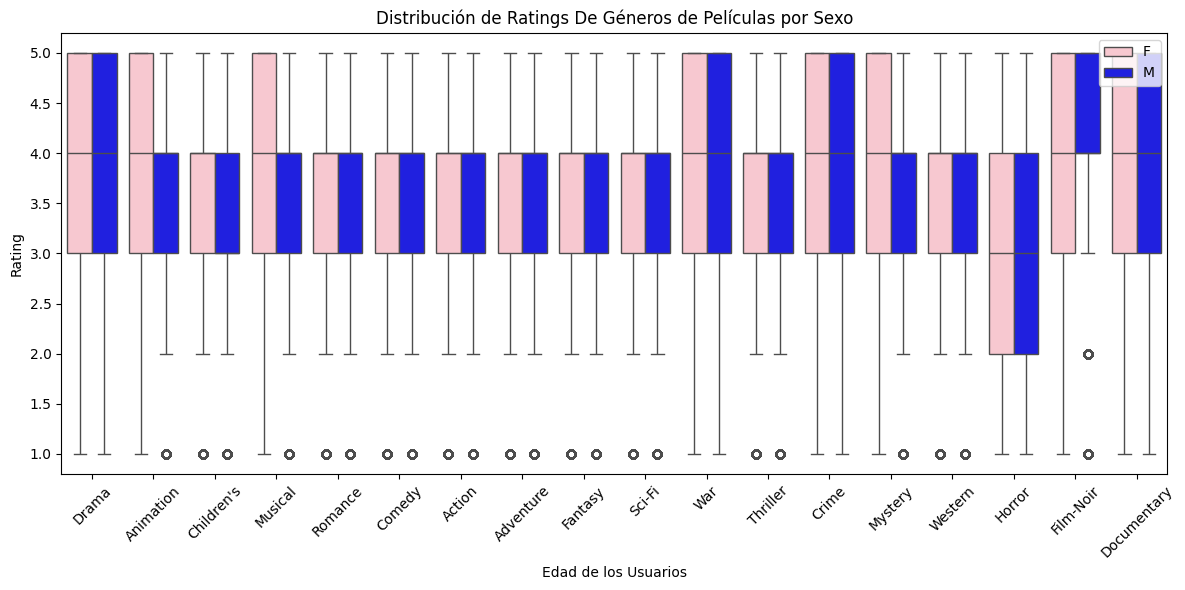

In [317]:
paleta = sns.color_palette("tab20", 18)
plt.figure(figsize=(12,6))
sns.boxplot(x='Genres', y='Rating', hue='Gender',data=df, palette=['pink', 'blue'])
plt.xticks(rotation=45)
plt.title('Distribución de Ratings De Géneros de Películas por Sexo')
plt.xlabel('Edad de los Usuarios')
plt.ylabel('Rating')
plt.legend(title='Grupo de Edad')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

En cuanto a esta gráfica:

- **Drama, War, Crime, Documentary**: Estos géneros de películas son bien recibidos por ambos sexos, presentando la mayoría de ratings entre las 3 y 5 estrellas, observando que también sus calificaciones son muy variables ya que muestran calificaciones de hasta 1 estrella sin considerarse dato atípico.

- **Animation, Musical, Mystery**: Las personas del género femenino tienden a calificar mejor a estas películas, centrándose en su mayoría de 3 a 5 estrellas, mientras que para el género masculino, las calificaciones se encuentran entre 3 y 4 estrellas.

- **Children´s, Romance, Comedy, Action, Adventure, Fantasy, Sci-Fi, Thriller, Western** este tipo de películas tienen un comportamiento similar independientemente del género del usuario, presentando la mayoría de ratings entre las 3 a 4 estrellas, y teniendo algunos datos atípicos en 1 estrella.

- **Horror**: Nuevamente podemos ver que este género de películas es el menos disfrutado independientemente del género o edad del usuario, presentando votaciones de 2 a 4 estrellas en su mayoría.

- **Film-Noir**: Este género tiene mejores calificaciones de los usuarios masculinos, entre 4 y 5 estrellas a comparación de los usuarios femeninos.

De estas gráficas podemos ver que según los datos del usuario, puede llegar a disfrutar más de un género de película que de otro, y esto influye directamente en el rating que vaya a colocar en una película no vista, por lo que esta información es importante para el modelo final.

En cuanto al Estado, se tienen registros de más de 50 estados o entidades federativas, por lo que es complicado verlo en un boxplot como los vistos antes, de igual manera se tienen 21 registros diferentes de ocupaciones lo cual hace complicado ver el comportamiento en una boxplot.

En su lugar haremos uso de un mapa de calor, que nos presentará la correlación de las diferentes variables con el target, observando si es que realmente afecta el resultado y de esta forma conservaremos únicamente las variables de interes, para esto procederemos a eliminar primero la información ed las columnas que ya habíamos mencionado antes y posteriormente haremos el heatmap.

In [318]:
df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,State
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,MI
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Animation,MI
2,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Children's,MI
3,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),Musical,MI
4,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),Musical,MI


In [319]:
df = df.drop(['Zip-code', 'Title', 'Timestamp'], axis=1)

df.head()

,UserID,Gender,Age,Occupation,MovieID,Rating,Genres,State
0,1,F,1,10,1193,5,Drama,MI
1,1,F,1,10,661,3,Animation,MI
2,1,F,1,10,661,3,Children's,MI
3,1,F,1,10,661,3,Musical,MI
4,1,F,1,10,914,3,Musical,MI


In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101815 entries, 0 to 2101814
Data columns (total 8 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   UserID      int64 
 1   Gender      object
 2   Age         int64 
 3   Occupation  int64 
 4   MovieID     int64 
 5   Rating      int64 
 6   Genres      object
 7   State       object
dtypes: int64(5), object(3)
memory usage: 128.3+ MB


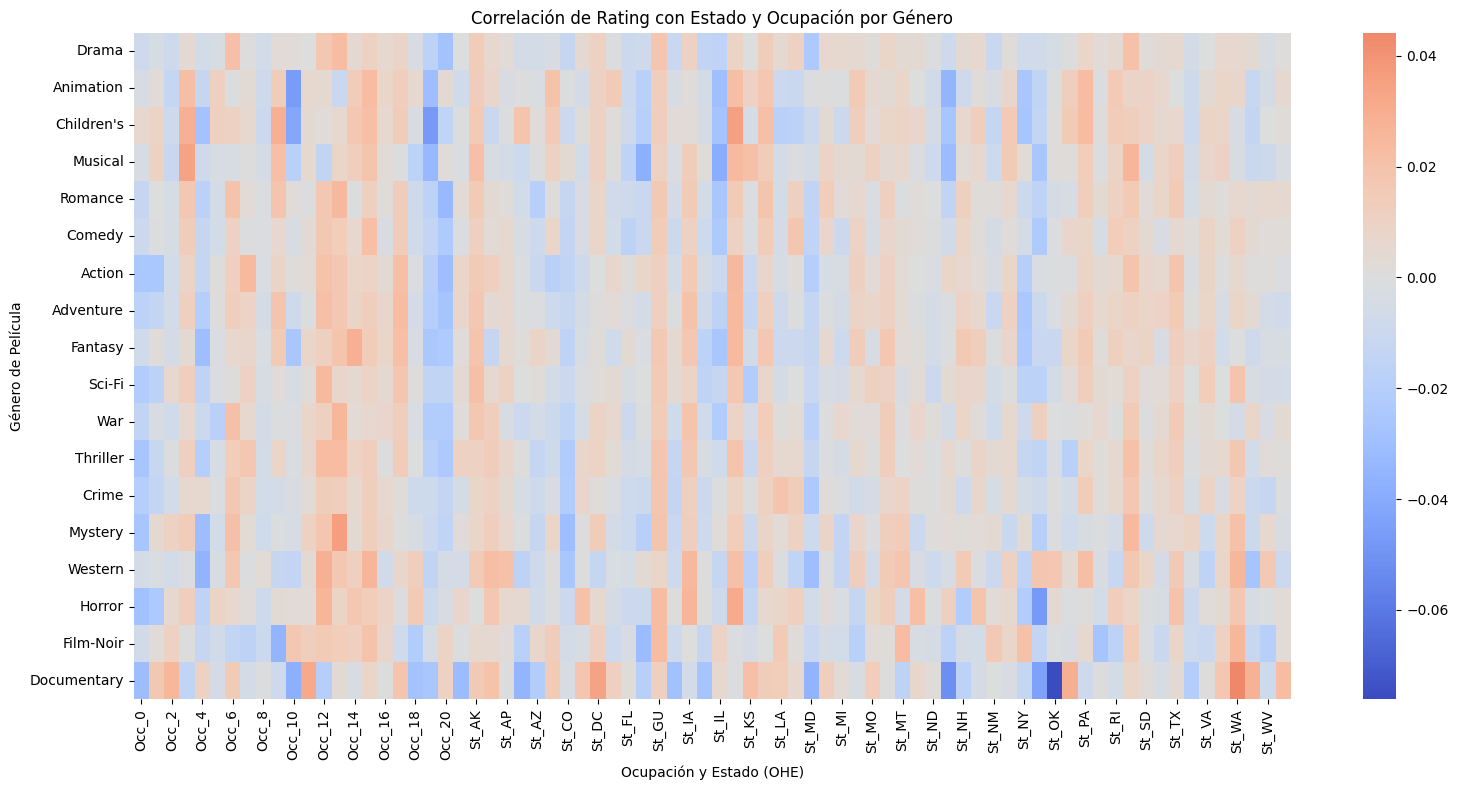

In [321]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Se hace un OHE en State porque es categórica, y se hace un OHE en occupation para que los números del 1 al 20 en la columna original no se tomen como importancia numérica, ya que no es así
df_ohe = pd.get_dummies(df, columns=['Occupation', 'State'], prefix=['Occ', 'St'])

#Agrupar por género y vamos a calcular la correlación con el género de películas
genres = df_ohe['Genres'].unique()
correlation_by_genre = {}

for genre in genres:
    sub_df = df_ohe[df_ohe['Genres'] == genre]
    #vamos a calcular la correlación de cada género con únicamente occupation y state, desechamos las demás
    corr = sub_df.drop(columns=['Gender', 'Age', 'MovieID', 'Genres', 'UserID']).corr(numeric_only=True)
    rating_corr = corr['Rating'].drop('Rating', errors='ignore')
    correlation_by_genre[genre] = rating_corr

#Crear DataFrame con correlaciones
correlation_df = pd.DataFrame(correlation_by_genre).T.fillna(0)

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_df, cmap='coolwarm', center=0, annot=False)
plt.title('Correlación de Rating con Estado y Ocupación por Género')
plt.xlabel('Ocupación y Estado (OHE)')
plt.ylabel('Género de Película')
plt.tight_layout()
plt.show()


En esta gráfica podemos ver que la mayoría de las correlaciones son escencialmente bajas, cercanas a 0, esto se ve por los colores más pálidos dentro de la gráfica, lo que indica que ni la ocupación ni el estado de una persona pueden influir realmente en el rating que le darán a cierta película de un cierto género.

Aún con esto, hay algunas de las ocupaciones y Estados que sí llegan a tener algunas correlaciones con los distintos géneros de películas, por ejemplo, las personas de St_OK se ve que tienden a dar mejores ratings a películas de Documentales que al resto de géneros.

Pero estas pequeñas relaciones no se sienten lo suficientemente fuertes como para incluirlas en el modelo, por lo que tendremos que descartar también las variables Occupation y State, ya que podríamos incluir ruido en el modelo, complicando mucho más de lo necesario y llegando a crear sobreajuste.

Por lo que las variables finales para el modelo son:

Gender, Age, y Genres, que nos ayudarán a predecir la variable Rating.

## Modelo

En nuestro caso de plantea un modelo de aprendizaje supervisado cuya finalidad es hacer predicciones sobre la calificación que un usuario le dará a una película no antes vista, este problema puede solucionarse usando un modelo de RandomForest como se ha estado mencionando desde el comienzo, para esta sección haremos 3 cosas:

Ajustar el modelo inicial con los hiperparámetros por defecto, posteriormente intentaremos mejorarlo un poco más por medio de una GrindSearchCV para diversos hiperparámetros.

Para finalizar, nos quedará observar si el modelo está o no sobreajustado para poder asegurar que llegue a tener alguna utilidad para datos no antes vistos.

Debemos mencionar que, como vimos nuestro target está desbalanceado, así que haremos uso del hiperparámetro: class_weight='balanced' desde un inicio para intentar solucionar este problema, además de integrar el parámetro para la división estratificada en las demás características.

Por las razones ya mencionadas anteriormente, vamos a quitar las columnas State y Occupation de la base de datos.

Cómo features únicamente incluiremos Gender, Age y Genres

Cómo Target usaremos la variable Rating

Por último, si bien las variables UserID y MovieID no son de utilidad para el modelo, serán conservadas para obtener una base de datos que nos servirá para observar que calificación le puso algún usuario a una película que no haya visto, ya que dentro de los usuarios y los diversos MovieID que se tienen, existen algunas películas que no han visto, y queremos ver que calificación le darían a dicha película.

In [322]:
df = df.drop(['Occupation', 'State'], axis=1)

In [323]:
df.head()

,UserID,Gender,Age,MovieID,Rating,Genres
0,1,F,1,1193,5,Drama
1,1,F,1,661,3,Animation
2,1,F,1,661,3,Children's
3,1,F,1,661,3,Musical
4,1,F,1,914,3,Musical


Algo importante que debemos tener en cuenta es que este problema en específico puede tratarse con una solución de clasificación o una de regresión, ya que estamos buscando predecir datos numéricos, pero a su vez estos datos son discretos y podrían tomarse como categorías, imaginando un 1 = Pésima, 2 = Mala, 3 = Mid, 4 = Buena y 5 = Excelente.

Realmente la decisión entre uno u otro se basaría en varias cosas:

Si nos interesan los datos directamente como enteros es mejor usar el Clasificador directamente. Pero esto ocasionaría que se pierda el orden de las clases, es decir, el "nivel" de una película del 1 al 5, ya que el modelo lo tomaría únicamente como una clase sin más.

En cuanto a la regresión, si de respetaría el orden, pero, al predecir valores continuos, puede ser que haya valores fuera de rango (menor a 1 o mayor a 5) además de que los datos ya no se manejarían como enteros si no como números reales. Realmente esto se puede solucionar con un redondeo simple.

Lo que haremos será realizar el primer ajuste del modelo con parámetros base + los parámetros que combaten el desbalanceo y observar cuál de las dos posibles soluciones ofrece un mejor resultado en base a las métricas de evaluación correspondientes, finalmente se elegirá un camino entre uno u otro y procederemos a realizar ajuste de parámetros.



Una cosa más antes de empezar, y será el último preprocesamiento de los datos antes de comenzar el modelaje:

Como podemos ver, un mismo MovieID se puede repetir varias veces, ya que la película llega a tener múltiples géneros, así que se pensó en hacer lo siguiente:

Realizar un OHE para la variable Genre, creando varias columnas binarias para cada género y posteriormente juntar todas las columnas por el mismo movieID, así veremos también el resultado por las "combinaciones" de géneros, por ejemplo, en un pequeño fragmento de la base de datos tenemos los datos de la película 661 que es de Animation, Children's y Musical, en las columnas binarias generadas por OneHotEncoder aparecía algo como:


  * UserID	Gender	Age	MovieID	Rating	Animation  Childrens  Musical  
  * 1	$\hspace{1.5cm}$ F$\hspace{1cm}$1$\hspace{.8cm}$661$\hspace{1.cm}$3$\hspace{1.2cm}$1$\hspace{1.5cm}$0 $\hspace{1.5cm}$ 0
  * 1	$\hspace{1.5cm}$ F$\hspace{1cm}$1$\hspace{.8cm}$661$\hspace{1.cm}$3$\hspace{1.2cm}$0$\hspace{1.5cm}$1 $\hspace{1.5cm}$ 0
  * 1	$\hspace{1.5cm}$ F$\hspace{1cm}$1$\hspace{.8cm}$661$\hspace{1.cm}$3$\hspace{1.2cm}$0$\hspace{1.5cm}$0 $\hspace{1.5cm}$ 1

Por lo que después de este procesamiento de los datos tendríamos una variable final tipo:

* UserID	Gender	Age	MovieID	Rating	Animation  Childrens  Musical  

* 1	$\hspace{1.5cm}$ F$\hspace{1cm}$1$\hspace{.8cm}$661$\hspace{1.cm}$3$\hspace{1.2cm}$1$\hspace{1.5cm}$1 $\hspace{1.5cm}$ 1

De esta forma también evitamos las muchas combinaciones del mismo usuario con la misma película.

In [324]:
#OneHotEncoder para la variable Genres, de momento sólo modificamos esta, la variable Gender será modificada antes de hacer el modelo
df_ohe = pd.get_dummies(df, columns=['Genres'])

#Para la agrupación crearemos un diccionario, donde vamos a especificar que tomaremos la primera aparición de gender, age y rating para cada movieID que se va a agrupar
#Se puede tomar la primera ya que da igual, en todos los casos de una movieID y un usuario se tiene siempre el mismo gender, age y rating
agg_dict = {
    'Gender': 'first',
    'Age': 'first',
    'Rating': 'first',
}

# Añadir columnas de géneros al diccionario con max
#Para cada columna en las columnas generadas por el OHE vamos a generar un título con Genre_NombreVariableEncontrada
#y los datos dentro de cada variable sea el máximo, el máximo pues es 1, entonces para cada género si es que aparece en la base original, las columnas generadas conservarán un 1
#Y será máximo 1, porque a pesar de que pueda repetirse un género, lo importante es que agruparemos por el ID de película y usuario, así que no tendremos valores mayores a 1 en ninguna de estas
#entradas de datos
for col in df_ohe.columns:
    if col.startswith('Genres_'):
        agg_dict[col] = 'max'

#Agrupamos por las combinaciones de UserID y de MovieID
#Aplicamos las funciones de diccionario que ya creamos, la de tomar el primer valor de Gender, Age y Rating y la de tomar los géneros que aparecieron
#se resetea el índice para evitar algunos movimientos raros del índice y que todo siga bien
df = df_ohe.groupby(['UserID', 'MovieID']).agg(agg_dict).reset_index()



In [325]:
df.head()

,UserID,MovieID,Gender,Age,Rating,Genres_Action,Genres_Adventure,Genres_Animation,Genres_Children's,Genres_Comedy,...,Genres_Fantasy,Genres_Film-Noir,Genres_Horror,Genres_Musical,Genres_Mystery,Genres_Romance,Genres_Sci-Fi,Genres_Thriller,Genres_War,Genres_Western
0,1,1,F,1,5,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,48,F,1,5,False,False,True,True,False,...,False,False,False,True,False,True,False,False,False,False
2,1,150,F,1,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,260,F,1,4,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,1,527,F,1,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [326]:
#únicamente no se nos olvide convertir las columnas tipo boolean en numéricas

booleancols = [
    'Genres_Action', 'Genres_Adventure', 'Genres_Animation', "Genres_Children's",
    'Genres_Comedy', 'Genres_Crime', 'Genres_Documentary', 'Genres_Drama',
    'Genres_Fantasy', 'Genres_Film-Noir', 'Genres_Horror', 'Genres_Musical',
    'Genres_Mystery', 'Genres_Romance', 'Genres_Sci-Fi', 'Genres_Thriller',
    'Genres_War', 'Genres_Western'
]

df[booleancols] = df[booleancols].astype(int)

Finalmente con los datos ya por fin procesados, podemos comenzar el modelo.

Comenzando con el Clasificador RF

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   UserID              1000209 non-null  int64 
 1   MovieID             1000209 non-null  int64 
 2   Gender              1000209 non-null  object
 3   Age                 1000209 non-null  int64 
 4   Rating              1000209 non-null  int64 
 5   Genres_Action       1000209 non-null  int64 
 6   Genres_Adventure    1000209 non-null  int64 
 7   Genres_Animation    1000209 non-null  int64 
 8   Genres_Children's   1000209 non-null  int64 
 9   Genres_Comedy       1000209 non-null  int64 
 10  Genres_Crime        1000209 non-null  int64 
 11  Genres_Documentary  1000209 non-null  int64 
 12  Genres_Drama        1000209 non-null  int64 
 13  Genres_Fantasy      1000209 non-null  int64 
 14  Genres_Film-Noir    1000209 non-null  int64 
 15  Genres_Horror       1000209 non-

In [328]:
#Para clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


#Para regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#para ambos
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [329]:
#Para empezar seleccionamos las variables que vamos a usar como características y target, en nuestro caso las características son todas las columnas menos las 3 aquí abajo escritas
X = df.drop(columns=['UserID', 'MovieID', 'Rating'])
y = df['Rating']

#Separamos los datos categóricos de los datos numéricos
cat_features = X.select_dtypes(include="object").columns.tolist()
num_features = X.select_dtypes(include=["int64"]).columns.tolist()

#Creamos de nuevo el pipeline con  One Hot Encoder, recordemos que el pipeline es una secuencia de pasos para manejar de manera adecuada los modelos, se incluye el preprocesamiento,
#la formación de modelo y evaluación
#En este caso nosotros aquí hacemos el preprocesamiento y el uso de un modelo, después se hace la evaluación
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)],
    remainder="passthrough")

#Este es el pipeline donde se incluye el preprocesamiento y modelo
modelo = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=170119, class_weight='balanced'
    ))
])

#Separamos los datos, usando 30% para test y el resto para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=170119, stratify = y)

#Ajustamos el modelo
modelo.fit(X_train, y_train)

#Evaluamos el modelo
y_pred = modelo.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("\n", classification_report(y_test, y_pred))

[[ 7830  3016  1447  1272  3287]
 [11503  6125  3420  3471  7748]
 [21161 13593  9347 10740 23518]
 [22972 14310 11268 15995 40147]
 [11936  6835  4878  9194 35050]]

               precision    recall  f1-score   support

           1       0.10      0.46      0.17     16852
           2       0.14      0.19      0.16     32267
           3       0.31      0.12      0.17     78359
           4       0.39      0.15      0.22    104692
           5       0.32      0.52      0.39     67893

    accuracy                           0.25    300063
   macro avg       0.25      0.29      0.22    300063
weighted avg       0.31      0.25      0.24    300063



Veamos las primeras observaciones respecto a este modelo, para empezar, podemos notar que el modelo no tiene un buen desempeño en la mayoría de clases, aunque presenta una buena clasificación cuando vemos la clase de 5 estrellas, teniendo una precisión del 32%, Recall del 52% y F1-score del 39%, recordemos que:

  - Recall: Verdadero Positivo entre la suma de Verdadero Positivo + Falso Negativo. De todos los casos que son positivos, ¿Qué porcentaje encontró el modelo?
  - Precision: Proporción de predicciones positivas que fueron correctas. Verdadero Positivo entre Verdadero Positivo + Falso Positivo. De todos los casos donde dijimos que era positivo, ¿En cuántos se tiene razón?
  - F1-score: Media armónica entre precisión y recall, buscando equilibrio entre ambas, es alta si y sólo si la accuracy y recall lo son.

En cuanto a la accuracy del modelo en general (Porcentaje de predicciones correctas que hace un modelo, la suma de los Verdaderos Positivos + Falsos Negativos entre el total) se tiene un 25%, casi casi lo de adivinar al azar entre las 5 clases (20%)

In [330]:
#Modelo 2, es decir, el RF regressor

#Pipeline para el RFRegressor
modelo2 = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        random_state=170119
    ))
])

#División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=170119
)

#entrenamiento
modelo2.fit(X_train, y_train)

#Predicción
y_pred = modelo2.predict(X_test)

#métricas RF regresion
print("Random Forest Regressor Métricas")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R² score: {r2_score(y_test, y_pred)}")

Random Forest Regressor Métricas
RMSE: 1.070660245790319
MAE: 0.8703458786494599
R² score: 0.08130868355438237


En cuanto al modelo de regresión, se tiene que el error absoluto medio, MAE es de 0.87, este resultado indica el promedio de las diferencias absolutas entre los valores predichos y los reales. Es decir, entre la clasificación dada por un usuario y la predicha por el modelo se tiene una diferencia en promedio de 0.87, si el usuario dió una estrella el modelo detectó que el usuario dió entre -0.87 y 1.87 en promedio, en términos de valores enteros, serían resultados entre 1 y 2, lo cual no es tan grave como en el caso anterior de clasificación que para muchas de 1 estrella el modelo asignó un valor de 5 estrellas.

Para el RMSE, es casi lo mismo que el MAE, en este caso se calcula la media de los errores cuadrados, sigue siendo de igual manera un número bajo teniendo únicamente un 1.07.

Entonces hasta el momento este parece llegar a ser un mejor modelo que el clasificador, pero no es así, la última métrica $R^2$ indica que el modelo sólo explica un 8% de la varianza de la variable rating, es decir, que tan variados son los datos, por lo que no logra capturar bien el comportamiento de la variabilidad real, lo que nos hace pensar que puede sólo estar memorizando información.

Con esto en mente, ambos modelos son muy pobres aún, falta enriquecerlos más, aún con esto, el modelo de clasificador parece tener un mejor desempeño que el de regresión, por lo que haremos un ajuste de hiperparámetros para el primer modelo, los hiperparámetros a ingresar son los más conocidos:

n_estimators	Número de árboles en el bosque, mientras más mejor, pero también más costo computacional, el modelo inicial se ajustó con 200 árboles, en los parámetros colocaremos 100, 150 y 250 debido a la limitación computacional que tenemos.

max_depth	Profundidad máxima de cada árbol, esto nos ayudará al tema del sobreajuste y evitar que el modelo se aprenda los datos en lugar de aprender de los datos, para esto primero no colocaremos un límite, después estableceremos un límite de 15 y 20 hojas, por la misma razón del costo computacional.

min_samples_split	Mínimo número de muestras para dividir un nodo, esto nos permite controlar que cantidad de datos se necesitan para crear más nodos, si el valor es alto el árbol puede dejar de crecer antes de lo necesario, evitando sobreajuste, probaremos con valores "bajos" y valores altos


In [331]:
"""
#Debemos realizar el split denuevo con la estratificación, ya que se guardó la división que se hizo para regersión que no está estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=170119, stratify=y
)

#malla de parámetros
param_grid = {
    "classifier__n_estimators": [100, 150, 250],
    "classifier__max_depth": [None, 15, 20],
    "classifier__min_samples_split": [2, 10, 100],
}

#Realizamos la gridsearch, usando una cantidad de únicamente 3 folds (tardó al rededor de )
grid_search = GridSearchCV(
    estimator= modelo,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

#Nos vamos a basar en la métrica de accuracy para escoger el mejor modelo con los mejores hiperparámetros, con que sea mayor al 0.25 que teníamos al inicio nos daremos por bien servidos

grid_search.fit(X_train, y_train)


print("Hiperparámetros del 'mejor modelo':")
print(grid_search.best_params_)

print("\nAccuracy del 'mejor modelo':")
print(grid_search.best_score_)

#Por último una vez seleccionado el mejor modelo volvemos a ajustarlo a los datos y observamos los resultados
y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report en test set:")
print(classification_report(y_test, y_pred))

"""

'\n#Debemos realizar el split denuevo con la estratificación, ya que se guardó la división que se hizo para regersión que no está estratificada\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.3, random_state=170119, stratify=y\n)\n\n#malla de parámetros\nparam_grid = {\n    "classifier__n_estimators": [100, 150, 250],\n    "classifier__max_depth": [None, 15, 20],\n    "classifier__min_samples_split": [2, 10, 100],\n}\n\n#Realizamos la gridsearch, usando una cantidad de únicamente 3 folds (tardó al rededor de )\ngrid_search = GridSearchCV(\n    estimator= modelo,\n    param_grid=param_grid,\n    cv=3,\n    scoring=\'accuracy\',\n    n_jobs=-1\n)\n\n#Nos vamos a basar en la métrica de accuracy para escoger el mejor modelo con los mejores hiperparámetros, con que sea mayor al 0.25 que teníamos al inicio nos daremos por bien servidos\n\ngrid_search.fit(X_train, y_train)\n\n\nprint("Hiperparámetros del \'mejor modelo\':")\nprint(grid_search.best_params_)\n\nprin


NOTA: Realmente me hubiera gustado ver esta sección de hiperparámetros, pero mis recursos no dieron el ancho suficiente para lograrlo, por lo que nos vamos a saltar a la parte de sobreajuste del modelo RF clasificator.


In [332]:
from sklearn.metrics import accuracy_score

#Predicciones en train y test
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

#Exactitud para cada conjunto de datos
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Accuracy en entrenamiento: {acc_train}")
print(f"Accuracy en prueba: {acc_test}")
print(f"Diferencia (train - test): {acc_train - acc_test}")


Accuracy en entrenamiento: 0.256405092652104
Accuracy en prueba: 0.25608288925992206
Diferencia (train - test): 0.00032220339218191896


Los resultados muestran una accuracy similar para ambos conjuntos del modelo, lo que indica que el modelo NO está sobreajustado, lo que queda es verificar un mejor modelo mediante hiperparámetros, pero debido al costo computacional esto no pudo ser posible.